## Functions Declaration for Converting Coordinates

In [1]:
from pyproj import Proj, transform # Import necessary functions from pyproj library
import re # Import re module for regular expressions

# Function to convert coordinates from NZTM (New Zealand Transverse Mercator) projection to WGS84 (latitude, longitude)
def nztm_to_latlon(easting, northing):
    # Define NZTM (New Zealand Transverse Mercator) projection using <authority>:<code> syntax
    nztm = Proj(init="epsg:2193")  # EPSG code for NZTM
    
    # Define WGS84 (latitude, longitude) projection using <authority>:<code> syntax
    wgs84 = Proj(init="epsg:4326")  # EPSG code for WGS84
    
    # Convert coordinates from NZTM to WGS84
    lon, lat = transform(nztm, wgs84, easting, northing)
    return lat, lon


# Function to extract coordinates
def extract_coordinates(description):
    # Split the description into components
    easting_northing = description.split()

    # Remove any non-numeric characters from the components
    easting = int(re.sub(r'\D', '', easting_northing[0]))  # Remove non-digits (including 'E')
    northing = int(re.sub(r'\D', '', easting_northing[1]))  # Remove non-digits (including 'N')

    return nztm_to_latlon(easting, northing)

## Data Normalization

In [38]:
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import warnings  # To handle warnings
warnings.filterwarnings('ignore', category=FutureWarning)  # Ignore FutureWarnings

from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn

# Load the data from CSV file, explicitly setting the data type for specific columns to string
data = pd.read_csv('Data.csv', dtype={'Column_Name': str}, low_memory=False)

# Remove columns that are entirely null
data = data.dropna(axis=1, how='all')

# Convert 'Count Start Date' column to datetime format, specifying day-first format and coercing errors
data['Count Start Date'] = pd.to_datetime(data['Count Start Date'], dayfirst=True, errors='coerce')

# Get the average traffic volume for weekends
data['Weekend Traffic ADT'] = (data['Saturday Volume'].fillna(0) + data['Sunday Volume'].fillna(0)) / 2

# Filter data to include only records from '2018-02-09' onwards (Data with Location)
filtered_data = data[data['Count Start Date'] >= '2018-02-09']
# Remove rows where 'Description (location of traffic count)' is null
filtered_data = filtered_data.dropna(subset=['Description (location of traffic count)'])

# Apply function to extract coordinates and create new columns 'Latitude' and 'Longitude'
filtered_data[['Latitude', 'Longitude']] = filtered_data['Description (location of traffic count)'].apply(extract_coordinates).apply(pd.Series)

# List of features for normalization and plotting
features = [
    '5 Day ADT', 'Weekend Traffic ADT', 
    'AM Peak Volume', 'Mid Peak Volume', 'PM Peak Volume'
]

# Extract the features for normalization
traffic_data = filtered_data[features]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
normalized_data = scaler.fit_transform(traffic_data)

# Convert the normalized data back to a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=features)

# Reset indices to ensure alignment
filtered_data.reset_index(drop=True, inplace=True)
normalized_df.reset_index(drop=True, inplace=True)

# Add 'Required Columns' back to the normalized DataFrame
normalized_df['Road Name'] = filtered_data['Road Name']
normalized_df['Carriageway Start Name'] = filtered_data['Carriageway Start Name']
normalized_df['Carriageway End Name'] = filtered_data['Carriageway End Name']
normalized_df['Count Start Date'] = filtered_data['Count Start Date']
normalized_df['Latitude'] = filtered_data['Latitude']
normalized_df['Longitude'] = filtered_data['Longitude']

# Display the shape of original and normalized dataframes
print(f"Original data shape: {filtered_data.shape}")
print(f"Normalized data shape: {normalized_df.shape}")


Original data shape: (13024, 26)
Normalized data shape: (13024, 11)


## Clean Data

In [39]:
# Check for NaN values in normalized_df
nan_values = normalized_df.isna().sum()
print("NaN values in normalized_df:")
print(nan_values)

#Drop rows with NaN values
normalized_df.dropna(inplace=True)

print(f"Normalized data shape: {normalized_df.shape}")

NaN values in normalized_df:
5 Day ADT                  1
Weekend Traffic ADT        0
AM Peak Volume             0
Mid Peak Volume            0
PM Peak Volume             0
Road Name                  0
Carriageway Start Name    20
Carriageway End Name      10
Count Start Date           0
Latitude                   0
Longitude                  0
dtype: int64
Normalized data shape: (12993, 11)


## Using Elbow Method to find the Optimal K for K Means

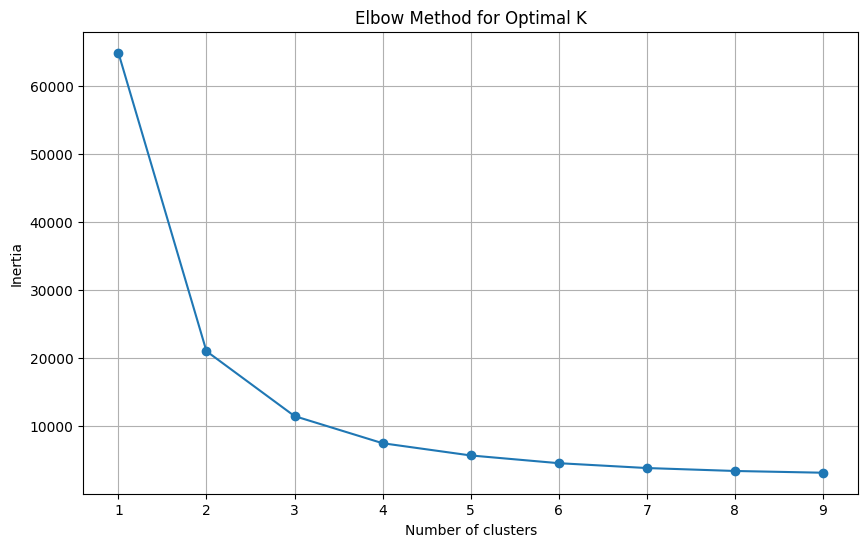

In [40]:
from sklearn.cluster import KMeans
# Finding the optimal number of clusters (K) using the elbow method
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_df[features])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [41]:
normalized_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12993 entries, 0 to 13023
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   5 Day ADT               12993 non-null  float64       
 1   Weekend Traffic ADT     12993 non-null  float64       
 2   AM Peak Volume          12993 non-null  float64       
 3   Mid Peak Volume         12993 non-null  float64       
 4   PM Peak Volume          12993 non-null  float64       
 5   Road Name               12993 non-null  object        
 6   Carriageway Start Name  12993 non-null  object        
 7   Carriageway End Name    12993 non-null  object        
 8   Count Start Date        12993 non-null  datetime64[ns]
 9   Latitude                12993 non-null  float64       
 10  Longitude               12993 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(3)
memory usage: 1.2+ MB
